<a href="https://colab.research.google.com/github/HamzaBahsir/NLP/blob/main/Recurrent_Neural_Networks_(RNNs).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 5b: Recurrent Neural Networks (RNNs)**


Recurrent Neural Networks (RNNs) are widely used in sequence-based tasks such as natural language processing, speech recognition, and time-series forecasting. They are designed to handle sequential data by maintaining a memory of past inputs, which helps in capturing dependencies in sequences.

# **Objectives:**
We will implement both a RNN model and apply it to a text-based dataset for time-series forecasting. Main objectives include:
* Understand the fundamentals of RNNs.

* Learn how to preprocess time-series data for neural networks.

* Implement and train RNN model using PyTorch.

* Evaluate the Model and plot the predictions.


# **Step 01 - Data Preparation**


*   Load the AirPassengers dataset from a URL and parse the date.
*   Normalize the dataset





In [ ]:
import pandas as pd
def load_data():
    """Loads the AirPassengers dataset."""
    url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
    data = pd.read_csv(url, parse_dates=['Month'], index_col='Month')
    return data

In [ ]:
# Load Data
data = load_data()
data.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


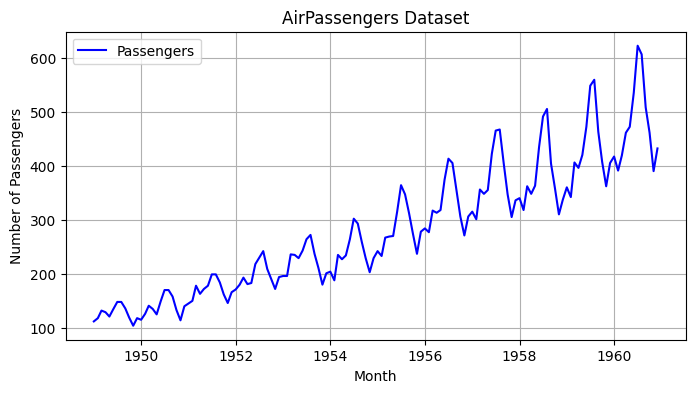

In [ ]:
import matplotlib.pyplot as plt

# Plot the data
plt.figure(figsize=(8, 4))
plt.plot(data.index, data['Passengers'], label='Passengers', color='blue')
plt.title('AirPassengers Dataset')
plt.xlabel('Month')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.show()


* NOTE: The plot shows the overall trend in passenger numbers over time.



In [ ]:
# Normalize the Dataset
from sklearn.preprocessing import MinMaxScaler
def normalize_data(data: pd.DataFrame) -> pd.DataFrame:
    """
   Normalize the dataset between 0 and 1.

    Args:
        data (pd.DataFrame): The raw time series data.

    Returns:
        pd.DataFrame: Normalized time series data.
    """
    # Initialize MinMaxScaler()
    scaler = MinMaxScaler()

    # Apply scaler.fit_transform() to normalize the dataset.
    data_scaled = scaler.fit_transform(data.values.reshape(-1, 1))

     # Return normalized data and scaler (needed for inverse transformation later)
    return data_scaled, scaler


In [ ]:
# Normalize Data
normalized_data, scaler = normalize_data(data)

* Since neural networks process fixed-length inputs, we need to convert time series data into sequences.
 Each input `X` consists of the past `seq_length` months, and the output `y` is the next month's value.


In [ ]:
import numpy as np
import torch
def create_sequences(data: np.ndarray, seq_length: int):
    """
    Converts time series data into sequences for training.

    Args:
        data (np.ndarray): The normalized time series data.
        seq_length (int): The sequence length (number of past months to consider).

    Returns:
        Tuple: (X, y) where:
               X -> Input sequences of shape (samples, seq_length)
               y -> Corresponding target values
    """
    # Initialize empty lists for sequences (X) and targets (y)
    sequences, targets = [], []

    # Iterate through data to create sequences
    for i in range(len(data) - seq_length):
        # Append a sequence of length `seq_length` to X
        sequences.append(data[i:i+seq_length])

        # Append the next value (target) to y
        targets.append(data[i+seq_length])

    # Convert lists to PyTorch tensors and return them
    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)



In [ ]:
# Create Sequences
seq_length = 12  # Using past 12 months as input
X, y = create_sequences(normalized_data, seq_length)

<ipython-input-5-fdf5bcfe933c>:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)


# **Step 02: Define RNN Model**


* Define the RNN model using [PyTorch](https://pytorch.org/docs/stable/index.html), a renowned tensor library for deep learning using GPUs and CPUs.

In [ ]:
import torch.nn as nn

class AirPassengersRNN(nn.Module):
    """
    Defines an RNN model for time series forecasting.
    """
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(AirPassengersRNN, self).__init__()

        # Define the RNN layer (use nn.RNN)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

        # Define the final fully connected layer (use nn.Linear)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Initialize hidden state (h0) as a zero tensor
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # Pass the input through the RNN layer
        out, _ = self.rnn(x, h0)

        # Pass the last time step's output through the fully connected layer
        out = self.fc(out[:, -1, :])

        # Return output
        return out





# **Step 03: Train the Model**
* Train the RNN model using Mean Squared Error (MSE) Loss and Adam optimizer.
* The model learns patterns in the dataset over multiple epochs.

In [ ]:
import torch.optim as optim

def train_model(model, X_train, y_train, num_epochs=100, learning_rate=0.001):
    """
    Trains the model (RNN or LSTM).

    Args:
        model: The RNN or LSTM model.
        X_train (Tensor): Training input sequences.
        y_train (Tensor): Corresponding targets.
        num_epochs (int): Number of training epochs.
        learning_rate (float): Learning rate for optimization.

    Returns:
        None
    """
    # Define the loss function (use nn.MSELoss())
    criterion = nn.MSELoss()

    # Define the optimizer (use optim.Adam())
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(X_train)

        # Compute loss
        loss = criterion(output, y_train)

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

        # Print loss every 10 epochs
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



In [ ]:
# Split Data into Train/Test Sets
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]



# Initialize and Train Model
model = AirPassengersRNN()
train_model(model, X_train, y_train)

Epoch [10/100], Loss: 0.0262
Epoch [20/100], Loss: 0.0218
Epoch [30/100], Loss: 0.0158
Epoch [40/100], Loss: 0.0080
Epoch [50/100], Loss: 0.0064
Epoch [60/100], Loss: 0.0060
Epoch [70/100], Loss: 0.0052
Epoch [80/100], Loss: 0.0048
Epoch [90/100], Loss: 0.0045
Epoch [100/100], Loss: 0.0040


# **Step 04: Evaluate the Model**
* Compute Root Mean Squared Error (RMSE) and plots predictions.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def evaluate_model(model, X_test, y_test, scaler, start_date='1949-01'):
    """
    Computes RMSE and plots predictions against actual values.

    Args:
        model: Trained PyTorch model.
        X_test: Test input data (shape: [n_samples, sequence_length, input_size]).
        y_test: Test target data (shape: [n_samples, output_size]).
        scaler: Scaler used to inverse transform predictions and actual values.
        start_date: Start date for the time axis (e.g., '1949-01').
    """
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        # Generate predictions
        predictions = model(X_test).numpy()

    # Inverse transform predictions and actual values
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
    y_test = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

    # Compute RMSE
    rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
    print(f'RMSE: {rmse:.4f}\n')

    # Create date range for the test set
    dates = pd.date_range(start=start_date, periods=len(y_test), freq='M')

    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(dates, y_test, label='Actual', color='blue')
    plt.plot(dates, predictions, label='Predicted', color='red', linestyle='--')
    plt.xlabel('Time (Months)')
    plt.ylabel('Number of Passengers')
    plt.title('Actual vs Predicted Passengers')
    plt.legend()
    plt.grid(True)
    plt.show()


RMSE: 59.5618



<ipython-input-10-99e2c176d4ae>:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start=start_date, periods=len(y_test), freq='M')


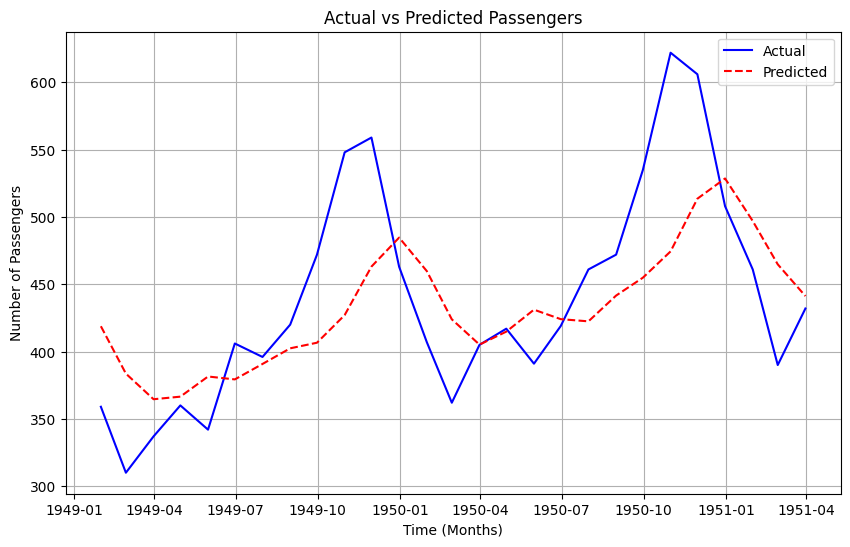

In [ ]:
# Evaluate the model
evaluate_model(model, X_test, y_test, scaler, start_date='1949-01')

If you want to explore RNNs, here is a [Tensorflow implementation of a Text Generator](https://www.geeksforgeeks.org/introduction-to-recurrent-neural-network/) leveraging the same.